# Tutorial: Working with Samples

In practice, we almost always work with samples from probability distributions rather than analytic or on-a-grid evaluations. Here we'll see how to do all the fun probability manipulations you've previously done (analytically and with grids) in the [Essential Probability](essential_probability.ipynb) tutorial, this time with Monte Carlo samples. 

Specifically, you will learn to:

* generate random samples from a probability distribution
* estimate marginal and conditional probabilities from Monte Carlo samples
* idenitfy when importance weighting might fail due to the samples' coverage

**Warning:** This notebook comes a little out of order. We will be doing things that are covered conceptually in the [Monte Carlo Sampling](../notes/montecarlo.ipynb) notes, so you may want to jump ahead and read their short _Motivation_ section. Or you could just take our word for a lot of things. This isn't ideal, but we think it's important to get you working with samples relatively early, even if the reasons why aren't fully apparent until later.

In [1]:
TutorialName = 'working_with_samples'
exec(open('tbc.py').read()) # define TBC and TBC_above
import numpy as np
import scipy.stats as st
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Produce some samples

Recalling our [Essential Probability](essential_probability.ipynb) tutorial, let's jump right into the case of 2 correlated Gaussian variables.

First we need some samples to work with. In this bivariate Gaussian case, `scipy` has a function that could generate samples for us, but instead let's test your understanding of what we've already covered.

First, let's specify the parameters of the distribution, as before:

In [2]:
cor = {'mx':1.0, 'my':2.3, 'sx':1.0, 'sy':0.5, 'r':-0.5} # parameter values
# Note that we do not need to explicitly define a function for the density this time!

Now, make an $N\times2$ table with each row being an $(x,y)$ pair, and $N$ being some large number of samples. Instead of using some fancy function to directly obtain samples of $(x,y)$, do this:
1. Fill the first column of the table ($x$) with samples from the marginal distribution, $p(x)$.
2. Fill the second column ($y$) with samples from the conditional distribution, $p(y|x)$.

You should have expressions for these two distributions already from the previous notebook.

In [34]:
N = 100000 # number of samples
samples = np.empty((N,2))
xys = np.random.multivariate_normal(
    [cor['mx'],cor['my']],[[cor['sx']**2,cor['r']*cor['sx']*cor['sy']],
                           [cor['r']*cor['sx']*cor['sy'],cor['sy']**2]], 
    size=N)
xs,ys=[],[]
for row in xys:
    xs.append(row[0])
    ys.append(row[1])
xs,ys=np.array(xs),np.array(ys)
samples[:,0] = xs
samples[:,1]= ys

Let's have a look. Qualitatively compare the plot below with the heatmap of $p(x,y)$ you made in the previous tutorial, for the case of correlated variables.

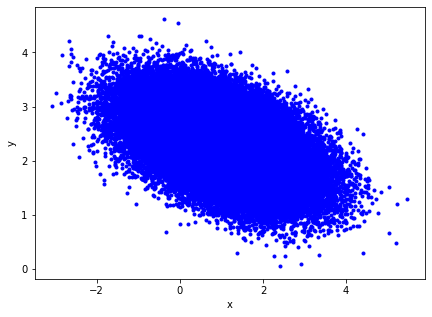

In [35]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.plot(samples[:,0], samples[:,1], 'b.');
plt.xlabel('x');
plt.ylabel('y');

## 2. Marginalization

Next, we'll look at estimates of the 1D marginal distributions from our samples. First, copy your implementations of the analytic solutions for these distributions from the previous notebook, so we have a known answer to compare to.

In [36]:
def cor_p_x(x, mx, my, sx, sy, r):
    return np.exp(-0.5/(1.0-r**2)* ((x-mx)/sx)**2 ) / (np.sqrt(2*np.pi)*sx)
def cor_p_y(y, mx, my, sx, sy, r):
    return np.exp(-0.5/(1.0-r**2)* ((y-my)/sy)**2 ) / (np.sqrt(2*np.pi)*sy)

In [37]:
# these are only used for plotting the above functions this time
xvalues = np.arange(-4.0, 6.0, 0.1)
yvalues = np.arange(-0.2, 4.8, 0.1)

If you read ahead to the [Monte Carlo Sampling](../notes/montecarlo.ipynb) notes, you've seen that the way we estimate a PDF from samples is by making a histogram (which simply records the density of the samples). Furthermore, the way we marginalize over a variable is incredibly simple - we just ignore it. So, estimating the marginal distribution of $x$ (or $y$) is as simple as making a histogram of the first (or second) column of `samples`.

To get a _normalized_ histogram, we use the `density=True` option below - this simply divides the number of samples in each histogram bin by the bin width and the total number of samples. Notice that we don't have one of the sanity checks here that we did previously, namely the ability to numerically check that our expression for the marginal PDF was normalized. (We can, however, plot it over our normalized histogram to check that it looks ok.)

Below we plot the density of samples generated above, using `hist`, and compare with your analytic solution from the previous notebook.

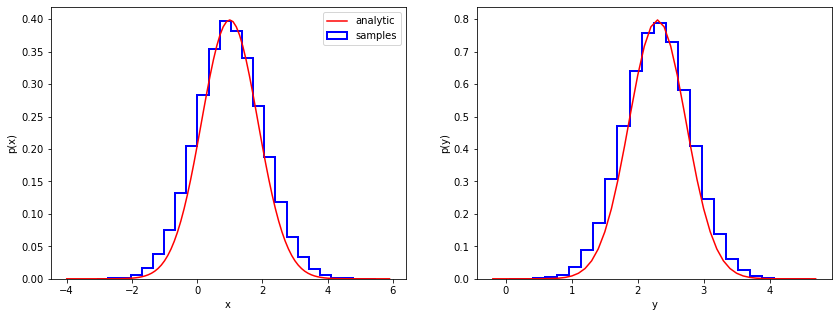

In [38]:
plt.rcParams['figure.figsize'] = (14.0, 5.0)
fig, ax = plt.subplots(1,2);
ax[0].hist(samples[:,0], bins=25, density=True, histtype='step', color='b', linewidth=2, label='samples');
ax[0].plot(xvalues, cor_p_x(xvalues, **cor), 'r-', label='analytic');
ax[0].set_xlabel('x');
ax[0].set_ylabel('p(x)');
ax[0].legend();
ax[1].hist(samples[:,1], bins=25, density=True, histtype='step', color='b', linewidth=2, label='samples');
ax[1].plot(yvalues, cor_p_y(yvalues, **cor), 'r-', label='analytic');
ax[1].set_xlabel('y');
ax[1].set_ylabel('p(y)');

## 3. Conditioning

Again, pull in your analytic solutions from the previous notebook.

In [39]:
def p_x_given_y(x, y, mx, my, sx, sy, r):
    return cor_p_xy(x, y, mx, my, sx, sy, r)/cor_p_y(y, mx, my, sx, sy, r)

def p_y_given_x(y, x, mx, my, sx, sy, r):
    return cor_p_xy(x, y, mx, my, sx, sy, r)/cor_p_x(x, mx, my, sx, sy, r)

In [40]:
# continuing to follow previous notebook
fixed_x = -1.0
fixed_y = 3.8

Conditioning is a little less straightforward than marginalization. In principle, if we want to condition on $x=x_0$, we would want to make a histogram of $y$ values for samples that have $x=x_0$. But we'd have to be incredibly lucky for any of our samples of $p(x,y)$ to satisfy $x=x_0$ exactly!

One natural (and necessarily approximate) solution is to work with samples that are _close_ to $x=x_0$, within some window. To that end, store in `j_fixed_x` a list of indices into `samples[:,0]` (i.e. row numbers) where $|y-y_0|<\epsilon$, where $y_0$ is `fixed_y`, above, and $\epsilon$ is a threshold of your choice. Do the equivalent for $x$ and `fixed_x` also.

In [62]:
epsilon=0.000001
xs,ys=samples[:,0],samples[:,1]
j_fixed_x=np.array((xs-fixed_x<epsilon).nonzero()[0])
j_fixed_y=np.array((ys-fixed_y<epsilon).nonzero()[0])

Now let's see how histograms of the samples you selected compare with the analytic solution in each case. Feel free to fiddle with the value of $\epsilon$ (and also the `bins` option to `hist`, below). How does it look?

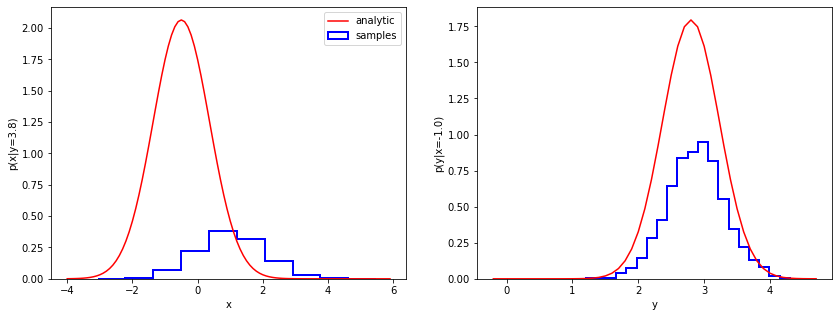

In [65]:
# fiddled with "bins" here to get something like the same resolution as elsewhere
plt.rcParams['figure.figsize'] = (14.0, 5.0)
fig, ax = plt.subplots(1,2);
ax[0].hist(samples[j_fixed_y,0], bins=10, density=True, histtype='step', color='b', linewidth=2, label='samples');
ax[0].plot(xvalues, p_x_given_y(xvalues, fixed_y, **cor), 'r-', label='analytic');
ax[0].set_xlabel('x');
ax[0].set_ylabel('p(x|y=' + str(fixed_y) + ')');
ax[0].legend();
ax[1].hist(samples[j_fixed_x,1], bins=20, density=True, histtype='step', color='b', linewidth=2, label='samples');
ax[1].plot(yvalues, p_y_given_x(yvalues, fixed_x, **cor), 'r-', label='analytic');
ax[1].set_xlabel('y');
ax[1].set_ylabel('p(y|x=' + str(fixed_x) + ')');

One obvious issue with this approach is that we end up with potentially many fewer samples in our estimate of the conditional distribution than we started with, so these histograms above will not look as pretty as the ones above. However, in this case, there are more than enough samples that the agreement with the analytic curve should be clear. **Checkpoint:** if the agreement is not clear, go back and check your work.

Let's see what fraction of the samples are actually used in the conditional histograms:

In [66]:
print(len(j_fixed_x) / samples.shape[0])
print(len(j_fixed_y) / samples.shape[0])

0.02278
0.99867


There's not much one can do about this "waste" of samples, other than to take the time to generate samples directly from the conditional distribution, if we care that much.

However, we might get slightly better (or smoother) results by changing the nature of the window used to select samples. For example, instead of completely throwing away samples that are farther than $\epsilon$ from a value we want to condition on, we could use all the samples, weighted in such a way that the samples far from $x_0$ or $y_0$ contribute much less than those that are nearby. To that end, compute Gaussian weights for each sample based on their distance from $y_0$ (or $x_0$), with a standard deviation that you again get to pick.

In [69]:
import scipy.stats as st
weights_fixed_x = st.norm.pdf(samples[:,0]-fixed_x)
weights_fixed_y = st.norm.pdf(samples[:,1]-fixed_y)

Again, fiddle with the standard deviation and/or display binning to see what you can do. (Note the use of the `weights` option.)

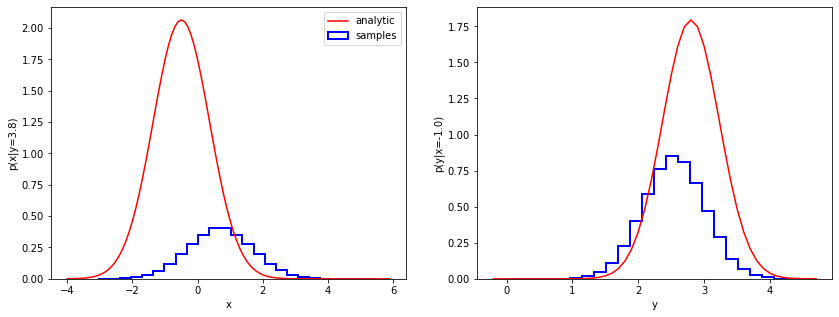

In [70]:
plt.rcParams['figure.figsize'] = (14.0, 5.0)
fig, ax = plt.subplots(1,2);
ax[0].hist(samples[:,0], weights=weights_fixed_y, bins=25, density=True, histtype='step', color='b', linewidth=2, label='samples');
ax[0].plot(xvalues, p_x_given_y(xvalues, fixed_y, **cor), 'r-', label='analytic');
ax[0].set_xlabel('x');
ax[0].set_ylabel('p(x|y=' + str(fixed_y) + ')');
ax[0].legend();
ax[1].hist(samples[:,1], weights=weights_fixed_x, bins=25, density=True, histtype='step', color='b', linewidth=2, label='samples');
ax[1].plot(yvalues, p_y_given_x(yvalues, fixed_x, **cor), 'r-', label='analytic');
ax[1].set_xlabel('y');
ax[1].set_ylabel('p(y|x=' + str(fixed_x) + ')');

Chances are that neither of these options looks great, so if we really cared about having the conditional PDF mapped well we would either want more samples, or we would need to sample from the conditional PDF directly instead of dealing with the conditioning this way.

On the other hand, if we just wanted to estimate something simple about the conditional PDF, say its mean, this might be good enough. Using the Gaussian-weighting method, the estimated mean of $x|y=3.8$ is:

In [71]:
np.sum(samples[:,0]*weights_fixed_y) / np.sum(weights_fixed_y)

0.6980169044730599

... compared with the exact mean of $-0.5$.

## 4. Importance weighting

Let's go a little farther and think more generally about the marginal distribution of $y$ from the product of $p(x,y)$ and some other PDF, $q(x)$. Imagine that we have samples of $p(x,y)$ that were expensive to get, while $q(x)$ is straightforward to evaluate for any $x$. Then, instead of investing a lot of time in generating new samples from $p(x,y)\,q(x)$, we might want to do something like the weighting procedure above, which is called _importance weighting_.

We can think of conditioning as importance weighting with a PDF that says that $x$ must be _really_ close to $x_0$, for example. But now, let's consider a different case. To keep it simple, let's say that $q(x) = \mathrm{Normal}(x|4,1)$. The weights for each sample are:

In [72]:
nu = 4.0 # giving things names is rarely a bad thing
tau = 1.0
weights_q = st.norm.pdf(samples[:,0], loc=nu, scale=tau)

Looking at the marginal distributions below, you can see how the marginal distribution of $x$ is, naturally, pulled to larger $x$, but also the PDF of $y$ is pulled to _lower_ $y$ due to the negative correlation of $p(x,y)$.

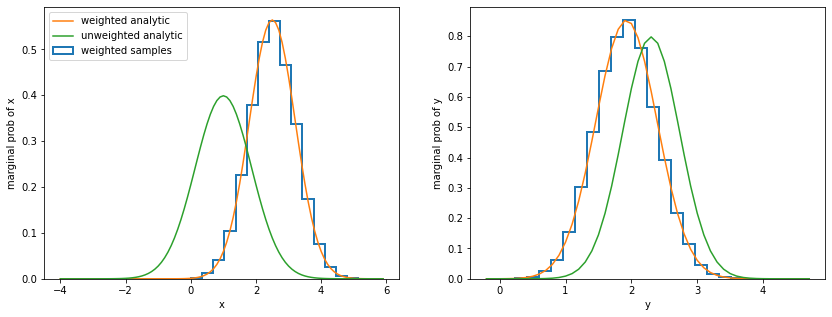

In [74]:
s = 1.0/np.sqrt( 1.0/cor['sx']**2 + 1.0/tau**2 )
m = s**2*( cor['mx']/cor['sx']**2 + nu/tau**2 )
anax = st.norm.pdf(xvalues, m, s)
s = 1.0/np.sqrt( 1.0/cor['sy']**2 + 1.0/(tau**2 + cor['sx']**2*(1.0-cor['r']**2)) )
m = s**2*( cor['my']/cor['sy']**2 + ((nu-cor['mx'])*cor['sy']/(cor['r']*cor['sx'])+cor['my'])/(tau**2 + cor['sx']**2*(1.0-cor['r']**2)) )
anay = st.norm.pdf(yvalues, m, s)

plt.rcParams['figure.figsize'] = (14.0, 5.0)
fig, ax = plt.subplots(1,2);
ax[0].hist(samples[:,0], weights=weights_q, bins=25, density=True, histtype='step', linewidth=2, label='weighted samples');
ax[0].plot(xvalues, anax, '-', label='weighted analytic');
ax[0].plot(xvalues, cor_p_x(xvalues, **cor), '-', label='unweighted analytic');
ax[0].set_xlabel('x');
ax[0].set_ylabel('marginal prob of x');
ax[0].legend();
ax[1].hist(samples[:,1], weights=weights_q, bins=25, density=True, histtype='step', linewidth=2, label='weighted samples');
ax[1].plot(yvalues, anay, '-', label='weighted analytic');
ax[1].plot(yvalues, cor_p_y(yvalues, **cor), '-', label='unweighted analytic');
ax[1].set_xlabel('y');
ax[1].set_ylabel('marginal prob of y');

The plots above also include analytic versions of the weighted distributions. We won't derive them here, but you can work it out with a little patience (see the [Gaussians and Least Squares](gaussians.ipynb) notebook). If you do, note that we've thrown away a constant, since we want to compare to the weighted histogram of samples, which is normalized when plotted above, whereas e.g. $\int dy \, p(x,y)\,q(x)$ is not automatically normalized the way that $\int dy \, p(x,y)$ is.

It looks like the weighting of the samples worked just about perfectly, to the extent that we can tell by eye. This is because the original set of $p(x,y)$ samples has good coverage of the region where the _product_ $p(x,y) \, q(x)$ is large (i.e. there are a lot of samples there, thanks to producing a much larger number of samples initially). 
If we changed things so that the $q(x)$ pulled us farther into the tails of $p(x,y)$, the PDF estimate would get noisier, and eventually there would be no samples in the relevant region left to re-weight! On the other hand, if $q(x)$ had been skinnier, or if its mean had been closer to the mean of $p(x)$, we would still see the weighted samples matching the analytic solution well.

With this in mind, contrive a $q_2(x)$ such that the procedure above fails... **badly**.

In [75]:
weights_q2 = st.norm.pdf(samples[:,0]-fixed_x, loc=nu, scale=tau)

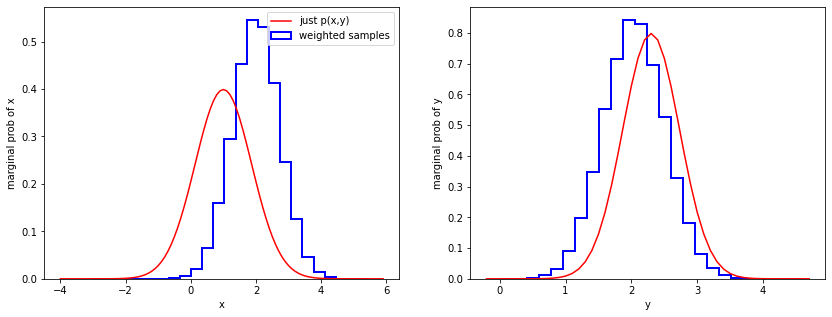

In [77]:
plt.rcParams['figure.figsize'] = (14.0, 5.0)
fig, ax = plt.subplots(1,2);
ax[0].hist(samples[:,0], weights=weights_q2, bins=25, density=True, histtype='step', color='b', linewidth=2, label='weighted samples');
ax[0].plot(xvalues, cor_p_x(xvalues, **cor), 'r-', label='just p(x,y)');
ax[0].set_xlabel('x');
ax[0].set_ylabel('marginal prob of x');
ax[0].legend();
ax[1].hist(samples[:,1], weights=weights_q2, bins=25, density=True, histtype='step', color='b', linewidth=2, label='weighted samples');
ax[1].plot(yvalues, cor_p_y(yvalues, **cor), 'r-', label='just p(x,y)');
ax[1].set_xlabel('y');
ax[1].set_ylabel('marginal prob of y');

**The lesson**: Importance weighting should only be used if the samples you have are sufficient to cover the region where the resulting PDF is significantly non-zero!